In [1]:
base_seed = 1300
n_seeds = 10

model_id = 'lv'
save_path = 'results/' + model_id

use_maf = False

noise_sd = 50.0  # compare to log(noise_sd) = 2.3 in Owen et al. 2014, Likelihood free inference for Makov Processes: a comparison

include_initial_state = True

# simulation setup
setup_opts = {        
    'n_hiddens': [50, 50],
    'reg_lambda': 0.01,
    'pilot_samples': 1000,
    'verbose': True,
    'prior_norm': False,    
    'svi': False,
    'n_rnn': 100,
    'n_inputs_rnn': 2
}

run_opts = {
    'n_train': 1000,
    'n_rounds': 10,
    'minibatch': 100,
    'epochs': 2000,
    'moo': 'resample',
    'proposal': 'gaussian',
    'n_null': None,
    'train_on_all': True,
    'max_norm': 0.1,
    'val_frac': 0.1,
    'silent_fail': False,
    'reuse_prior_samples': True,
}
  
if run_opts['train_on_all']:
    run_opts['epochs'] = [run_opts['epochs'] // (r+1) for r in range(run_opts['n_rounds'])]

if use_maf:
    # control MAF seed
    rng_maf = np.random
    
    setup_opts.update({
        'mode': 'random',
        'n_mades': 5,
        'rng': rng_maf,
        'act_fun': 'tanh',
        'batch_norm': False
    })

pars_true = np.array([-4.60517019, -0.69314718,  0.        , -4.60517019])  # from SNL paper
#x0 was generated by simulation using the true parameters from the SNL paper, initial state not removed, dt=0.2
raw_data = np.array([50., 100., 59., 104.,  66., 117.,  81., 133.,  97., 131., 109., 135., 127.,
       132., 148., 135., 163., 125., 188., 108., 217.,  95., 239.,  75.,
       236.,  60., 235.,  46., 228.,  34., 217.,  28., 211.,  18., 193.,
        12., 175.,   8., 171.,   9., 162.,   5., 151.,   5., 136.,   6.,
       128.,   6., 111.,   8., 110.,   8.,  96.,   8.,  95.,   9.,  93.,
         9.,  81.,  10.,  80.,  11.,  78.,  17.,  74.,  17.,  72.,  19.,
        66.,  20.,  67.,  25.,  64.,  29.,  54.,  30.,  55.,  45.,  54.,
        45.,  53.,  48.,  48.,  50.,  54.,  65.,  61.,  75.,  64.,  77.,
        65.,  95.,  73., 106.,  85., 107.,  88., 114., 104., 113., 130.,
       114., 159., 110., 173.,  95., 196.,  77., 220.,  72., 219.,  49.,
       212.,  33., 209.,  24., 196.,  18., 188.,  18., 176.,  17., 166.,
        15., 158.,  14., 154.,  10., 138.,  13., 128.,  11., 119.,  11.,
       107.,   9.,  99.,   8.,  94.,  11.,  86.,  11.,  81.,  12.,  78.,
        15.,  67.,  19.,  63.,  16.,  58.,  20.,  58.,  28.,  57.,  36.,
        53.,  39.,  55.,  44.,  53.,  44.,  55.,  44.,  54.,  49.,  54.,
        66.,  54.,  77.,  53.,  93.,  64.,  98.,  76., 100.,  94., 110.,
       116., 112., 136., 102., 149., 105., 173., 103., 200.,  95., 208.,
        69., 224.,  54., 232.,  47., 217.,  40., 206.,  29., 202.,  24.,
       196.,  24., 181.,  23., 167.,  13., 158.,  14., 147.,   9., 135.,
         8., 121.,   9., 111.,   8.,  95.,  10.,  84.,  10.,  73.,  11.,
        68.,  14.,  61.,  16.,  57.,  20.,  50.,  19.,  46.,  25.,  43.,
        33.,  41.,  38.,  42.,  40.,  45.,  50.,  48.,  57.,  48.,  60.,
        47.,  63.,  49.,  68.,  48.,  66.,  42.,  71.,  43.,  84.,  46.,
        81.,  40.,  89.,  45., 121.,  55., 134.,  67., 136.,  83., 135.,
       100., 142., 129., 135., 148., 134., 163., 130., 182., 111., 195.,
       106., 206.,  93., 216.,  67., 224.,  47., 207.,  33., 202.,  24.,
       193.,  20., 182.,  14., 174.,   8., 161.,   8., 152.,   4., 140.,
         6., 131.,   5.])
raw_data += np.random.randn(*raw_data.shape) * noise_sd
obs = raw_data if include_initial_state else raw_data[2:]

In [350]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
import timeit
from copy import deepcopy
from delfi.utils.progress import no_tqdm, progressbar

from delfi.utils.viz import plot_pdf
import delfi.inference as infer
import delfi.distribution as dd
import delfi.generator
from delfi.summarystats import Identity

from lfimodels.snl_exps.util import save_results, load_results, StubbornGenerator, stubborn_defaultrej
from lfimodels.snl_exps.util import  save_results_byname, load_results_byname
from lfimodels.snl_exps.util import init_g_lv as init_g
from lfimodels.snl_exps.util import load_setup_lv as load_setup
from lfimodels.snl_exps.util import load_gt_lv as load_gt
from lfimodels.snl_exps.util import calc_all_lprob_errs
from lfimodels.snl_exps.LotkaVolterra import LotkaVolterra, LotkaVolterraStats
import snl.simulators.lotka_volterra as sim_lv
from snl.util.plot import plot_hist_marginals

print('pars_true : ', pars_true)

dt = 0.2

pars_true :  [-4.60517019 -0.69314718  0.         -4.60517019]


In [ ]:
def plot_gaussian_sequence(x, ps, **kwargs):
    m = np.array([p.xs[0].m[k] for p in ps])
    s = np.array([np.sqrt(p.xs[0].S[k, k]) for p in ps])
    return plt.fill_between(x, m - s, m + s, **kwargs)

# compare rnn and stats with and without no noise

In [296]:
exp_ids_rnn_nonoise = [d for d in os.listdir(save_path) if d.startswith('rnn_nonoise_seed23')]
prnn_nonoise = []
for exp_id in exp_ids_rnn_nonoise:
    try:
        pstats, Vstats = load_results_byname(exp_id=exp_id, path=save_path)
    except:
        continue
    del Vstats
    if type(pstats[0]) is list:        
        #assert len(pstats) == 1
        pstats = pstats[-1]
    prnn_nonoise.append(pstats)

In [291]:
exp_ids_stats_nonoise = [d for d in os.listdir(save_path) if d.startswith('stats_fc_nonoise_seed23')]
pstats_nonoise = []
for exp_id in exp_ids_stats_nonoise:
    try:
        pstats, Vstats = load_results_byname(exp_id=exp_id, path=save_path)
    except:
        continue
    del Vstats
    if type(pstats[0]) is list:
        #assert len(pstats) == 1
        pstats = pstats[-1]
    pstats_nonoise.append(pstats)

In [292]:
exp_ids_rnn_noise = [d for d in os.listdir(save_path) if d.startswith('rnn_noise_seed13')]
prnn_noise = []
for exp_id in exp_ids_rnn_noise:
    try:
        pstats, Vstats = load_results_byname(exp_id=exp_id, path=save_path)
    except:
        continue
    del Vstats
    if type(pstats[0]) is list:
        #assert len(pstats) == 1
        pstats = pstats[-1]
    prnn_noise.append(pstats)

In [297]:
exp_ids_stats_noise = [d for d in os.listdir(save_path) if d.startswith('stats_fc_noise_seed13')]
pstats_noise = []
for exp_id in exp_ids_stats_noise:
    try:
        pstats, Vstats = load_results_byname(exp_id=exp_id, path=save_path)
    except:
        continue
    del Vstats
    if type(pstats[0]) is list:
        assert len(pstats) == 1
        pstats = pstats[0]
    pstats_noise.append(pstats)

In [ ]:
alpha = 0.1
rnn_color = 'teal'
stats_color = 'violet'

dim_param = pars_true.size
figh = plt.figure(figsize=(16,6))
for k in range(dim_param):
    ax = plt.subplot(2, dim_param, k+1)    
    for i, pps in enumerate(pstats_nonoise):
        nsamples = run_opts['n_train'] * (1.0 + np.arange(len(pps)))
        hstats = plot_gaussian_sequence(nsamples, pps, color=stats_color, alpha=alpha)#, label='stats')
        plt.plot(nsamples, [p.xs[0].mean[k] for p in pps], color=stats_color)
    for i, pps in enumerate(prnn_nonoise):
        nsamples = run_opts['n_train'] * (1.0 + np.arange(len(pps)))
        hrnn = plot_gaussian_sequence(nsamples, pps, color=rnn_color, alpha=alpha)#, label='rnn')
        plt.plot(nsamples, [p.xs[0].mean[k] for p in pps], color=rnn_color)
    plt.plot(plt.xlim(), np.ones(2) * pars_true[k],'k')
    plt.ylim(pars_true[k] + np.array([-1., 1.]) * .5)
    plt.xlim([0, 10000])
    plt.xlabel('Simulations')
    plt.ylabel('$\\theta_{0}$'.format(k))
    ax.set_aspect(10000.)
    if k == 0:
        plt.legend(loc='lower right')
        plt.title('Observationn noise $\\sigma = 0$')

    ax = plt.subplot(2, dim_param, k+1 + dim_param)    
    for i, pps in enumerate(pstats_noise):
        nsamples = run_opts['n_train'] * (1.0 + np.arange(len(pps)))
        hstats = plot_gaussian_sequence(nsamples, pps, color=stats_color, alpha=alpha)#, label='stats')
        plt.plot(nsamples, [p.xs[0].mean[k] for p in pps], color=stats_color)
    for i, pps in enumerate(prnn_noise):
        nsamples = run_opts['n_train'] * (1.0 + np.arange(len(pps)))
        hrnn = plot_gaussian_sequence(nsamples, pps, color=rnn_color, alpha=alpha)#, label='rnn')
        plt.plot(nsamples, [p.xs[0].mean[k] for p in pps], color=rnn_color)
    plt.plot(plt.xlim(), np.ones(2) * pars_true[k],'k')
    plt.ylim(pars_true[k] + np.array([-1., 1.]) * 5)
    plt.xlim([0, 10000])
    plt.xlabel('Simulations')
    plt.ylabel('$\\theta_{0}$'.format(k))
    ax.set_aspect(1000.)
    if k == 0:
        plt.legend(loc='lower right')
        plt.title('Observationn noise $\\sigma = 50$')
figh.tight_layout()

/opt/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


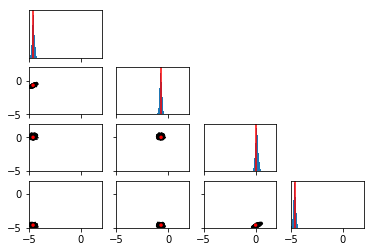

In [417]:
ii = 3
round_to_plot = 10
posterior_C = pstats_nonoise[ii][round_to_plot - 1]
g=g_rnn

g2 = deepcopy(g)
g2.proposal = posterior_C
samples = np.array(g2.draw_params(5000)) 

_ = plot_hist_marginals(samples,
                        gt=pars_true.flatten(),
                        lims=[[-5,2],[-5,2],[-5,2],[-5,2]])

In [396]:
ii

3

/opt/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


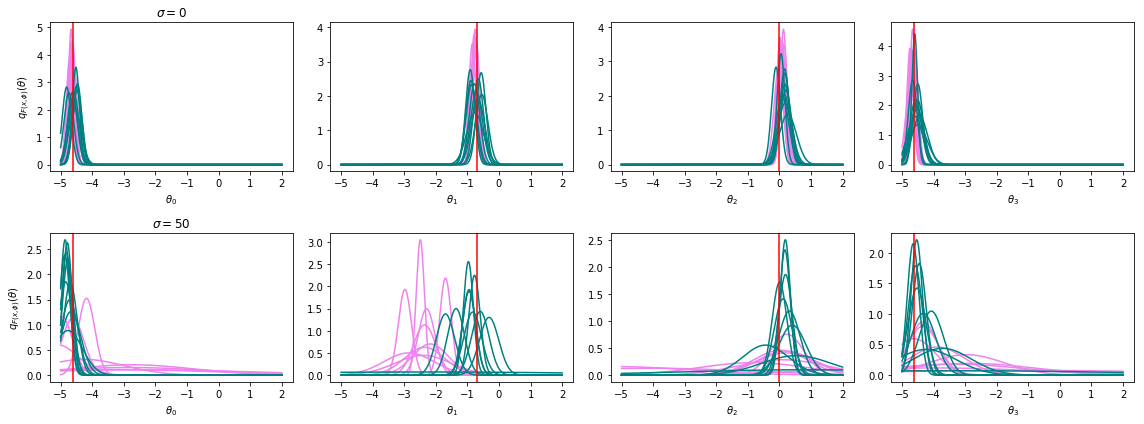

In [419]:
import scipy
figh = plt.figure(figsize=(16,6))

round_plot = 10
for k in range(dim_param):
    xx =  np.linspace(-5,2,5000)
    
    plt.subplot(2, 4, k + 1)
    for p in pstats_nonoise: 
        m = p[round_plot - 1].xs[0].m[k]
        V = p[round_plot - 1].xs[0].S[k,k]
        y = scipy.stats.norm.pdf(xx, m, np.sqrt(V))
        plt.plot(xx, y, color=stats_color)
    plt.xlabel('$\\theta_{0}$'.format(k))
    if k == 0:
        plt.ylabel('$q_{F(x,\\phi)}(\\theta)$')
        plt.title('$\\sigma = 0$')
        
    for p in prnn_nonoise: 
        m = p[round_plot - 1].xs[0].m[k]
        V = p[round_plot - 1].xs[0].S[k,k]
        y = scipy.stats.norm.pdf(xx, m, np.sqrt(V))
        plt.plot(xx, y, color=rnn_color)
        
    plt.subplot(2, 4, 4 + k + 1)
    for p in pstats_noise: 
        m = p[round_plot - 1].xs[0].m[k]
        V = p[round_plot - 1].xs[0].S[k,k]
        y = scipy.stats.norm.pdf(xx, m, np.sqrt(V))
        plt.plot(xx, y, color=stats_color)
    plt.xlabel('$\\theta_{0}$'.format(k))
    if k == 0:
        plt.ylabel('$q_{F(x,\\phi)}(\\theta)$')
        plt.title('$\\sigma = 50$')

        
    for p in prnn_noise: 
        m = p[round_plot - 1].xs[0].m[k]
        V = p[round_plot - 1].xs[0].S[k,k]
        y = scipy.stats.norm.pdf(xx, m, np.sqrt(V))
        plt.plot(xx, y, color=rnn_color)
        
for k in range(dim_param):
    plt.subplot(2, 4, k + 1)
    YL = plt.ylim()
    plt.plot(pars_true[k] * np.ones(2), YL, 'r')
    plt.ylim(YL)
    plt.subplot(2, 4, 4 + k + 1)
    YL = plt.ylim()
    plt.plot(pars_true[k] * np.ones(2), YL, 'r')
    plt.ylim(YL)
    
figh.tight_layout()

(-5, 40)

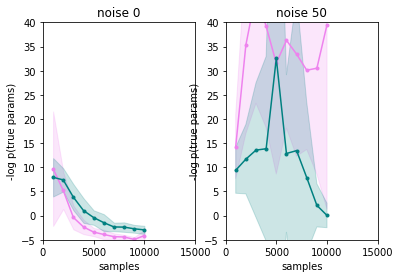

In [358]:
fill_alpha = 0.2

max_rounds = 10

plt.figure()


y = np.hstack([np.array([-pp.eval(pars_true.reshape(1, -1), log=True) for pp in ps])[:max_rounds] for ps in prnn_nonoise])
m_rnn_nonoise = y.mean(axis=1)
s_rnn_nonoise = y.std(axis=1)
y = np.hstack([np.array([-pp.eval(pars_true.reshape(1, -1), log=True) for pp in ps])[:max_rounds] for ps in prnn_noise])
m_rnn_noise = y.mean(axis=1)
s_rnn_noise = y.std(axis=1)
y = np.hstack([np.array([-pp.eval(pars_true.reshape(1, -1), log=True) for pp in ps])[:max_rounds] for ps in pstats_nonoise])
m_stats_nonoise = y.mean(axis=1)
s_stats_nonoise = y.std(axis=1)
y = np.hstack([np.array([-pp.eval(pars_true.reshape(1, -1), log=True) for pp in ps])[:max_rounds] for ps in pstats_noise])
m_stats_noise = y.mean(axis=1)
s_stats_noise = y.std(axis=1)

plt.subplot(1, 2, 1)

m, s, c = m_stats_nonoise, s_stats_nonoise, stats_color
plt.fill_between(nsamples, m-s, m + s, color=c, alpha=fill_alpha)

m, s, c = m_rnn_nonoise, s_rnn_nonoise, rnn_color
plt.fill_between(nsamples, m-s, m + s, color=c, alpha=fill_alpha)

plt.plot(nsamples, m_stats_nonoise, color=stats_color, marker='.')
plt.plot(nsamples, m_rnn_nonoise, color=rnn_color,marker='.')

plt.xlabel('samples')
plt.ylabel('-log p(true params)')
plt.title('noise 0')
plt.xlim([0, 10000])
plt.ylim([-5, 40])

plt.subplot(1, 2, 2)
m, s, c = m_stats_noise, s_stats_noise, stats_color
plt.fill_between(nsamples, m-s, m + s, color=c, alpha=fill_alpha)

m, s, c = m_rnn_noise, s_rnn_noise, rnn_color
plt.fill_between(nsamples, m-s, m + s, color=c, alpha=fill_alpha)

plt.plot(nsamples, m_stats_noise, color=stats_color,marker='.')
plt.plot(nsamples, m_rnn_noise, color=rnn_color, marker='.')

plt.xlabel('samples')
plt.ylabel('-log p(true params)')
plt.title('noise 50')
plt.xlim([0, 10000])
plt.ylim([-5, 40])

(-5, 50)

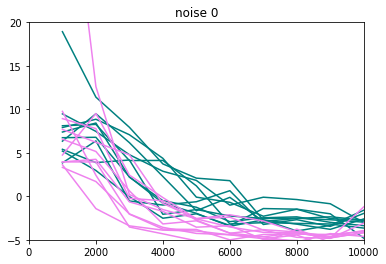

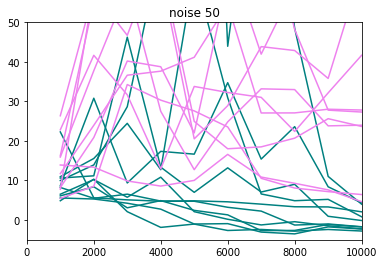

In [355]:
plt.figure()
for i, ps in enumerate(prnn_nonoise):
    nsamples = run_opts['n_train'] * (1.0 + np.arange(len(ps)))
    plt.plot(nsamples, [-pp.eval(pars_true.reshape(1, -1), log=True) for pp in ps], color=rnn_color)
for i, ps in enumerate(pstats_nonoise):
    nsamples = run_opts['n_train'] * (1.0 + np.arange(len(ps)))
    plt.plot(nsamples, [-pp.eval(pars_true.reshape(1, -1), log=True) for pp in ps], color=stats_color)    
plt.title('noise 0')
plt.xlim([0, 10000])
plt.ylim([-5, 20])

plt.figure()
for i, ps in enumerate(prnn_noise):
    nsamples = run_opts['n_train'] * (1.0 + np.arange(len(ps)))
    plt.plot(nsamples, [-pp.eval(pars_true.reshape(1, -1), log=True) for pp in ps], color=rnn_color)
for i, ps in enumerate(pstats_noise):
    nsamples = run_opts['n_train'] * (1.0 + np.arange(len(ps)))
    plt.plot(nsamples, [-pp.eval(pars_true.reshape(1, -1), log=True) for pp in ps], color=stats_color)    
plt.title('noise 50')
plt.xlim([0, 10000])
plt.ylim([-5, 50])

In [235]:
n_steps_used=(raw_data.shape[0] - 2)// 2
assert (n_steps_used + int(include_initial_state)) * 2 == obs.shape[0]
model = LotkaVolterra(dt=dt, duration=dt * n_steps_used, seed=seed, max_n_steps=50000, noise_sd=noise_sd)
prior = dd.Uniform(lower= [-5,-5,-5,-5], upper = [2,2,2,2], seed=seed)
summary = Identity(seed=seed)
g_rnn = StubbornGenerator(model=model, prior=prior, summary=summary, seed=seed)

n_steps_used=(raw_data.shape[0] - 2)// 2
assert (n_steps_used + int(include_initial_state)) * 2 == obs.shape[0]
model = LotkaVolterra(dt=dt, duration=dt * n_steps_used, seed=seed, max_n_steps=50000, noise_sdx=noise_sd)
prior = dd.Uniform(lower= [-5,-5,-5,-5], upper = [2,2,2,2], seed=seed)
summary = LotkaVolterraStats(seed=seed)
g_stats = StubbornGenerator(model=model, prior=prior, summary=summary, seed=seed)

/opt/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/opt/anaconda3/lib/python3.7/site-packages/matplotlib/contour.py:1230: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"


Text(0.5,0.98,'SNPE-C posterior estimates, round r = 10')

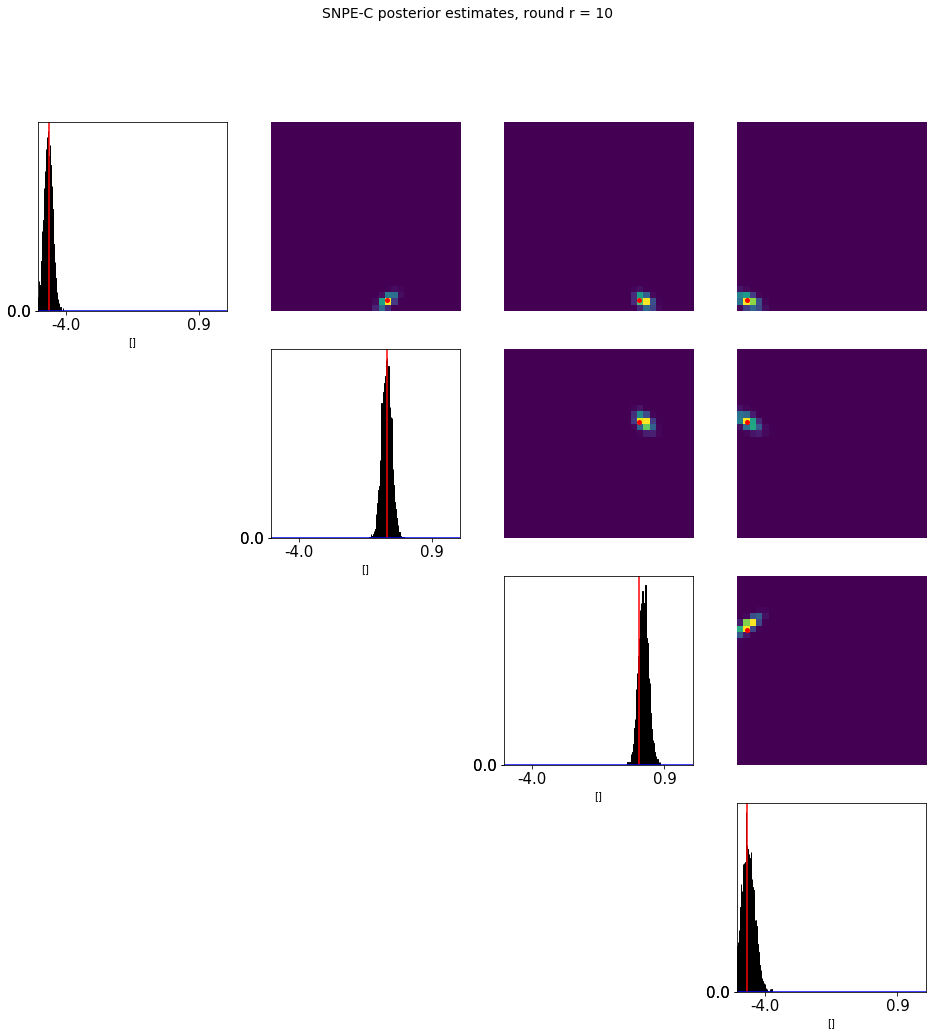

In [347]:
fig,_ = plot_pdf(dd.Gaussian(m=0.00000123*np.ones(pars_true.size), S=1e-30*np.eye(pars_true.size)), 
               samples=samples.T,
               gt=pars_true, 
               lims=[[-5,2],[-5,2],[-5,2],[-5,2]],
               #lims=[0,10],
               resolution=100,
               ticks=True,
               figsize=(16,16));

fig.suptitle('SNPE-C posterior estimates, round r = '+str(r+1), fontsize=14)